In [26]:
import os

import pandas as pd
import numpy as np

import networkx as nx

import matplotlib.pyplot as plt

from compute_correlations import compute_pearson_correlation, compute_kendall_correlation
from graphs import build_full_graph, build_threshold_graph, find_max_clique, find_max_independent_set

if not os.path.exists('images'):
    os.makedirs('images')

colors_by_season = {
    'winter' : 'lightblue',
    'spring' : 'pink',
    'autumn' : 'orange',
    'summer' : 'yellowgreen'
}

# thresholds_by_method = {
#     'kendall' : 0.3,
# }

thresholds_by_method = {
    'kendall' : {
        '3h' : 0.5,
        'daily' : 0.5,
        'weekly' : 0.5
    },
    'pearson' : {}
}

thresholds_by_method['pearson']['3h'] = thresholds_by_method['kendall']['3h'] * 0.7559 + 0.3342
thresholds_by_method['pearson']['daily'] = thresholds_by_method['kendall']['daily'] * 0.6544 + 0.4165
thresholds_by_method['pearson']['weekly'] = thresholds_by_method['kendall']['weekly']# * 0.7559 + 0.3342

TITLE_FONT_SIZE = 20
EDGE_LABEL_FONT_SIZE = 12

def load_temp_by_season_interval(season, interval):
    cities = ["msk", "spb", "kaz", "ufa", "nn", "novosib", "vlad"]
    df = pd.DataFrame(columns=cities)
    for city in cities:
        df[city] = pd.read_csv(f"result_datasets/{city}_df_{season}_{interval}.csv")["T"]
    return df

def draw_pearson_graph(df, threshold=0.0):
    vertices = df.columns
    edge_weights = compute_pearson_correlation(df)
    g = build_threshold_graph(vertices, edge_weights, threshold)
    pos = nx.spring_layout(g)
    pos = nx.circular_layout(g)
    nx.draw(g, pos, with_labels=True, node_color='cornflowerblue')
    edge_labels = {k: round(v, 2) for (k, v) in nx.get_edge_attributes(g, 'weight').items()}
    nx.draw_networkx_edge_labels(g, pos, edge_labels);

def draw_kendall_graph(df, threshold=0.0):
    vertices = df.columns
    edge_weights = compute_kendall_correlation(df)
    g = build_threshold_graph(vertices, edge_weights, threshold)
    pos = nx.spring_layout(g)
    pos = nx.circular_layout(g)
    nx.draw(g, pos, with_labels=True, node_color='cornflowerblue')
    edge_labels = {k: round(v, 2) for (k, v) in nx.get_edge_attributes(g, 'weight').items()}
    nx.draw_networkx_edge_labels(g, pos, edge_labels);

def draw_graph_forall_seasons_by_interval(interval, corr_method, threshold=0.5):
    fig, axs = plt.subplots(2, 2, figsize=(7, 7))
    seasons = ['winter', 'spring', 'autumn', 'summer']
    dfs = [load_temp_by_season_interval(season, interval) for season in seasons]
    fig.suptitle(f"{corr_method} correlation graphs ({interval}, threshold={np.round(thresholds_by_method[corr_method][interval], 2)})", fontsize=TITLE_FONT_SIZE)
    for i, (df, season) in enumerate(zip(dfs, seasons)):
        vertices = df.columns
        edge_weights = compute_pearson_correlation(df) if corr_method == 'pearson' else compute_kendall_correlation(df)
        g = build_threshold_graph(vertices, edge_weights, thresholds_by_method[corr_method][interval])
        pos = nx.circular_layout(g)
        nx.draw(g, pos, ax=axs.flatten()[i], with_labels=True, node_color=colors_by_season[season], font_weight='bold')
        axs.flatten()[i].set_title(f"{seasons[i]}", fontsize=20, fontweight='bold')
        edge_labels = {k: round(v, 2) for (k, v) in nx.get_edge_attributes(g, 'weight').items()}
        nx.draw_networkx_edge_labels(g, pos, edge_labels, ax=axs.flatten()[i]);
    fig.tight_layout()
    fig.savefig(f"images/graphs_{corr_method}_{interval}.png", dpi=300)
    
    
def draw_cliques_forall_seasons_by_interval(interval, corr_method, threshold=0.5):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    seasons = ['winter', 'spring', 'autumn', 'summer']
    dfs = [load_temp_by_season_interval(season, interval) for season in seasons]
    fig.suptitle(f"Max cliques for {corr_method} correlation graphs ({interval}, threshold={thresholds_by_method[corr_method][interval]})", fontsize=TITLE_FONT_SIZE)
    for i, (df, season) in enumerate(zip(dfs,seasons)):
        vertices = df.columns
        edge_weights = compute_pearson_correlation(df) if corr_method == 'pearson' else compute_kendall_correlation(df)
        threshold_graph = build_threshold_graph(vertices, edge_weights, thresholds_by_method[corr_method][interval])
        clique = find_max_clique(threshold_graph)
        pos = nx.circular_layout(clique)
        nx.draw(clique, pos, ax=axs.flatten()[i], with_labels=True, node_color=colors_by_season[season], font_weight='bold')
        axs.flatten()[i].set_title(f"{seasons[i]}", fontsize=20, fontweight='bold')
        edge_labels = {k: round(v, 2) for (k, v) in nx.get_edge_attributes(clique, 'weight').items()}
        nx.draw_networkx_edge_labels(clique, pos, edge_labels, ax=axs.flatten()[i]);
    fig.tight_layout()
    fig.savefig(f"images/cliques_{corr_method}_{interval}.png", dpi=300)
    
def draw_sets_forall_seasons_by_interval(interval, corr_method, threshold=0.5):
    fig, axs = plt.subplots(2, 2, figsize=(7, 7))
    seasons = ['winter', 'spring', 'autumn', 'summer']
    dfs = [load_temp_by_season_interval(season, interval) for season in seasons]
    fig.suptitle(f"Max ind. sets for {corr_method} correlation graphs ({interval}, threshold={thresholds_by_method[corr_method][interval]})", fontsize=TITLE_FONT_SIZE)
    for i, (df,season) in enumerate(zip(dfs,seasons)):
        vertices = df.columns
        edge_weights = compute_pearson_correlation(df) if corr_method == 'pearson' else compute_kendall_correlation(df)
        threshold_graph = build_threshold_graph(vertices, edge_weights, thresholds_by_method[corr_method][interval])
        iset = find_max_independent_set(threshold_graph)
        pos = nx.circular_layout(iset)
        nx.draw(iset, pos, ax=axs.flatten()[i], with_labels=True, node_color=colors_by_season[season], font_weight='bold')
        axs.flatten()[i].set_title(f"{seasons[i]}", fontsize=20, fontweight='bold')
    fig.tight_layout()
    fig.savefig(f"images/sets_{corr_method}_{interval}.png", dpi=300)


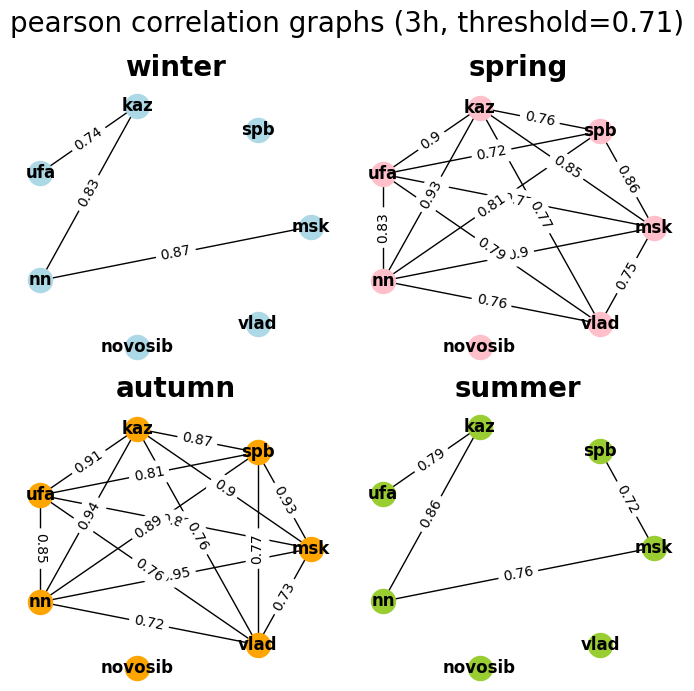

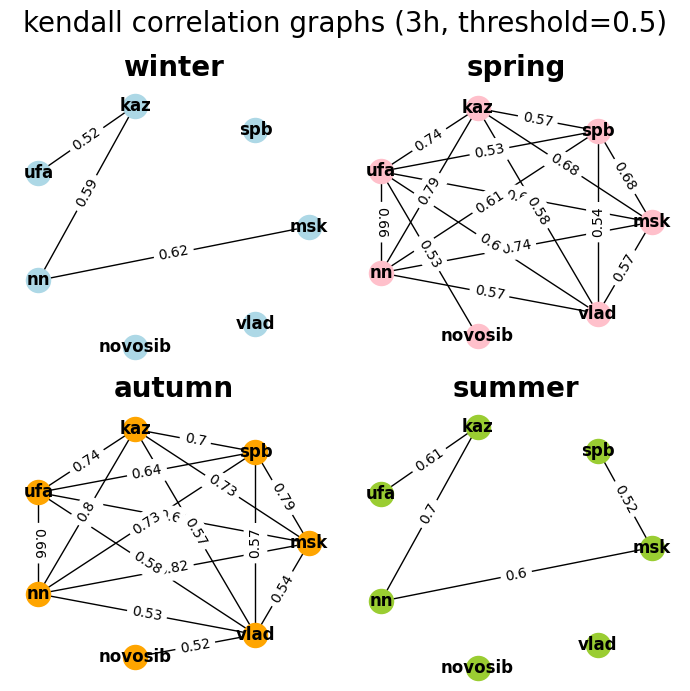

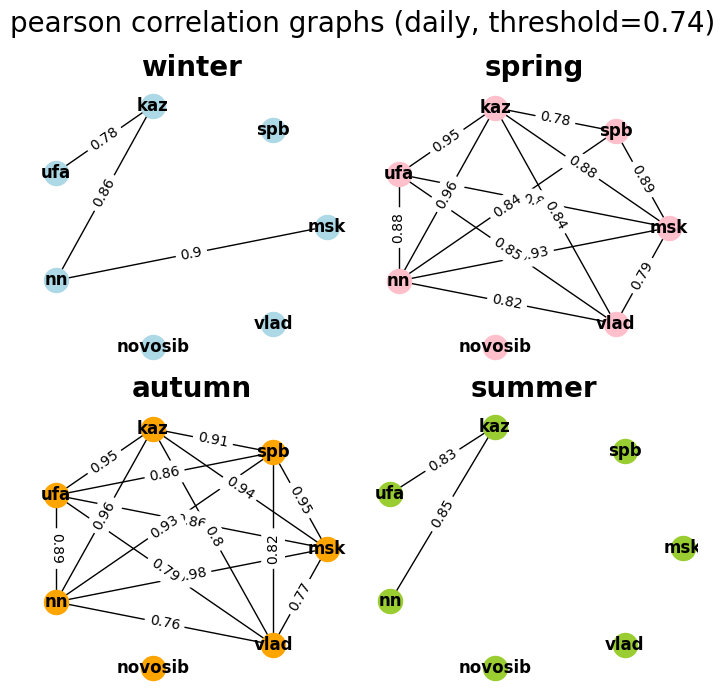

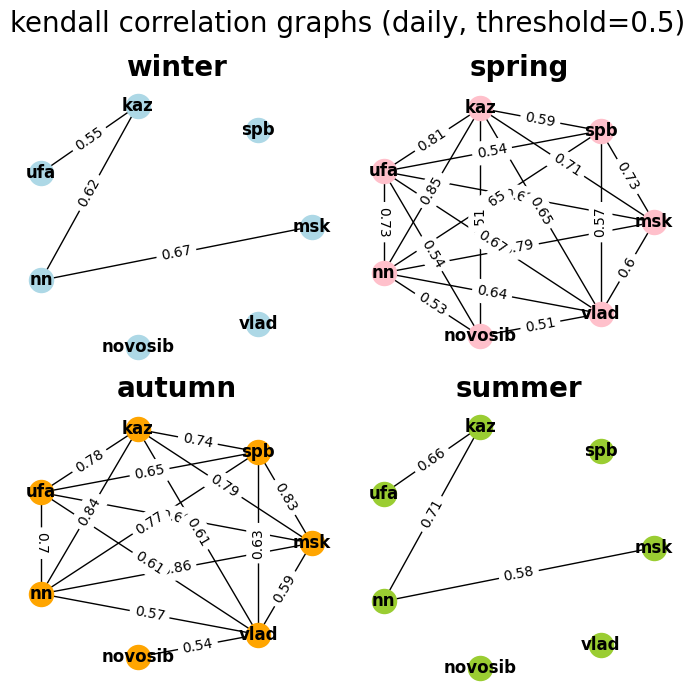

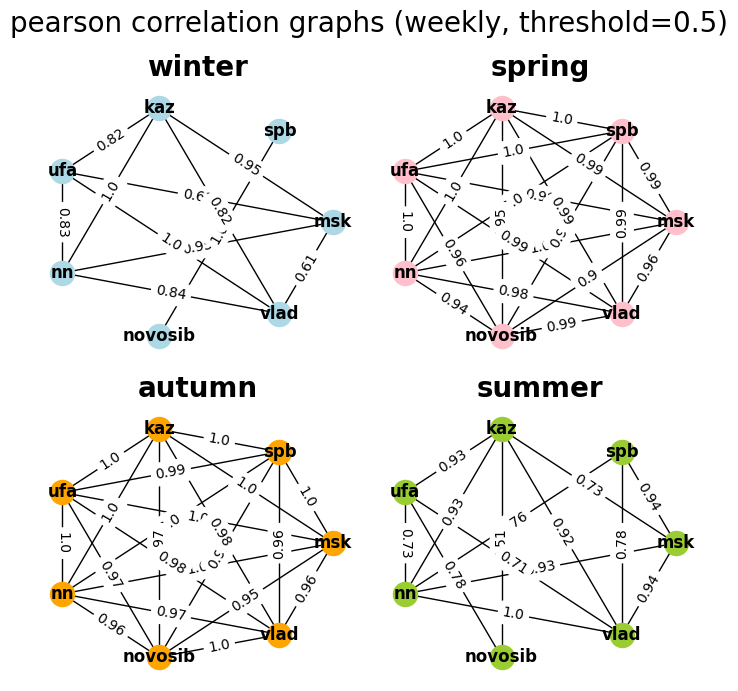

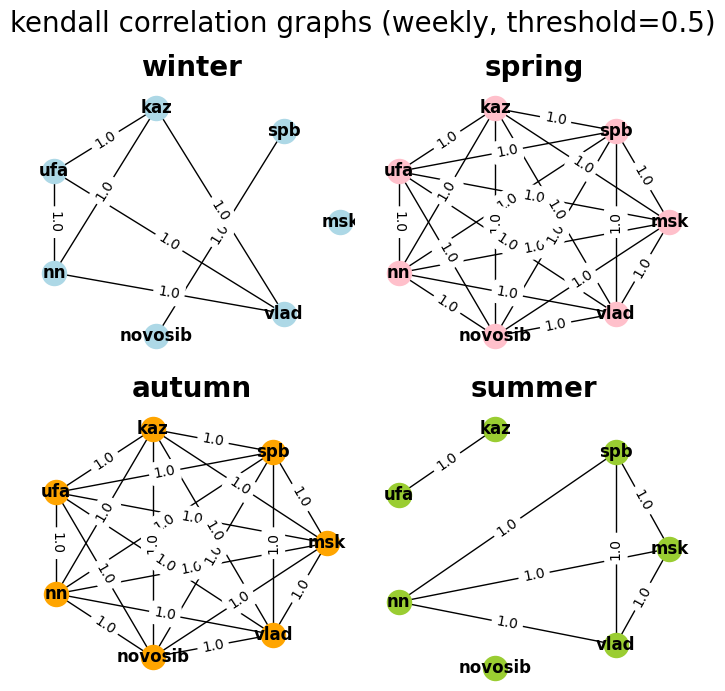

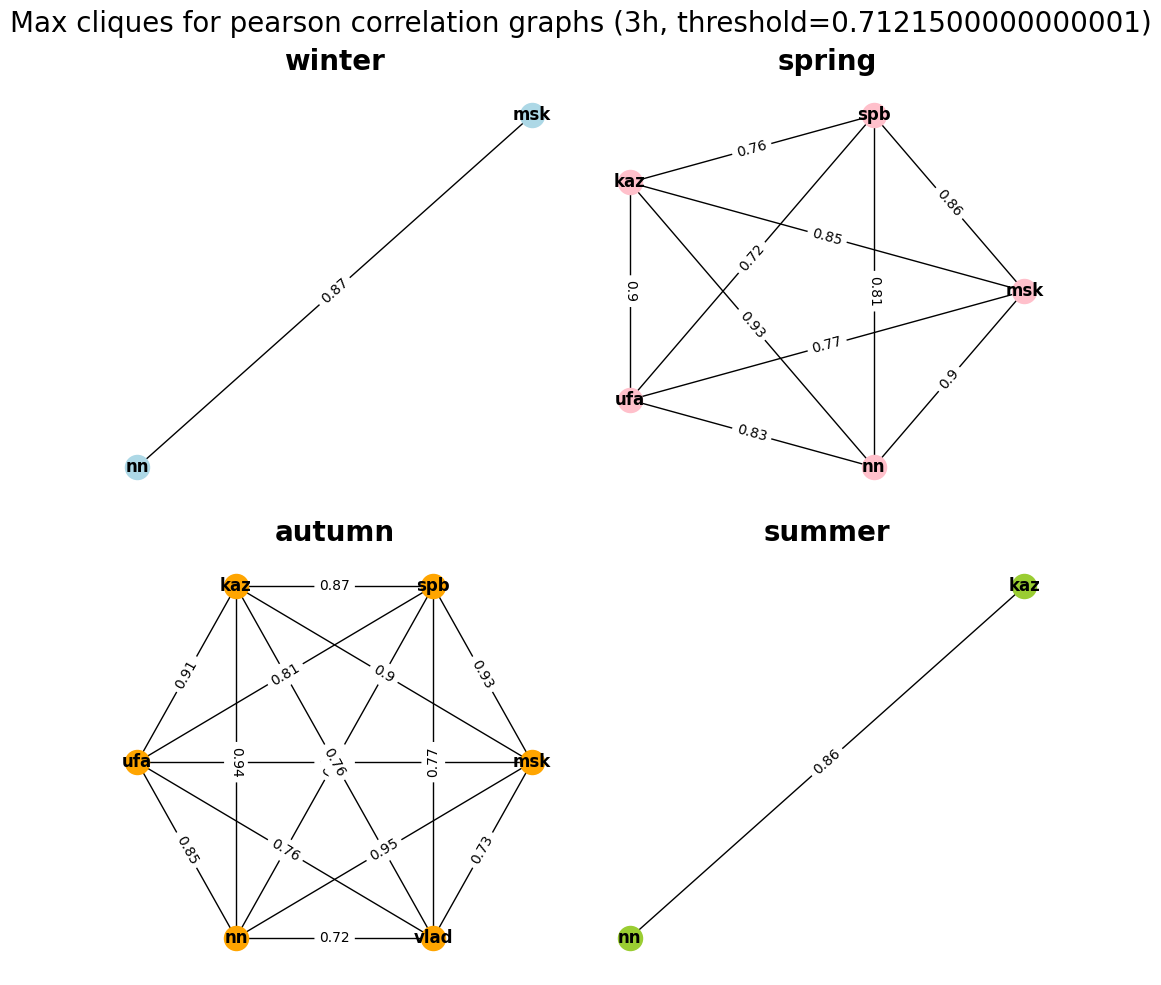

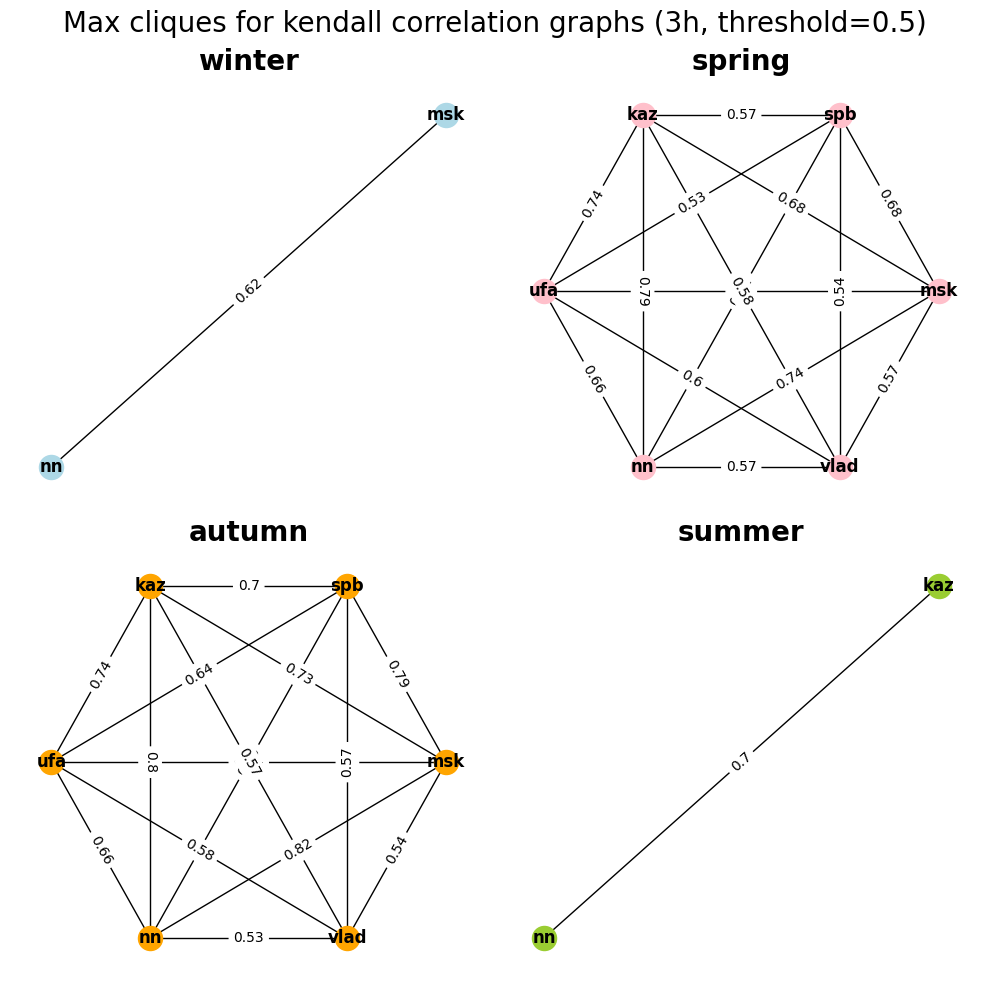

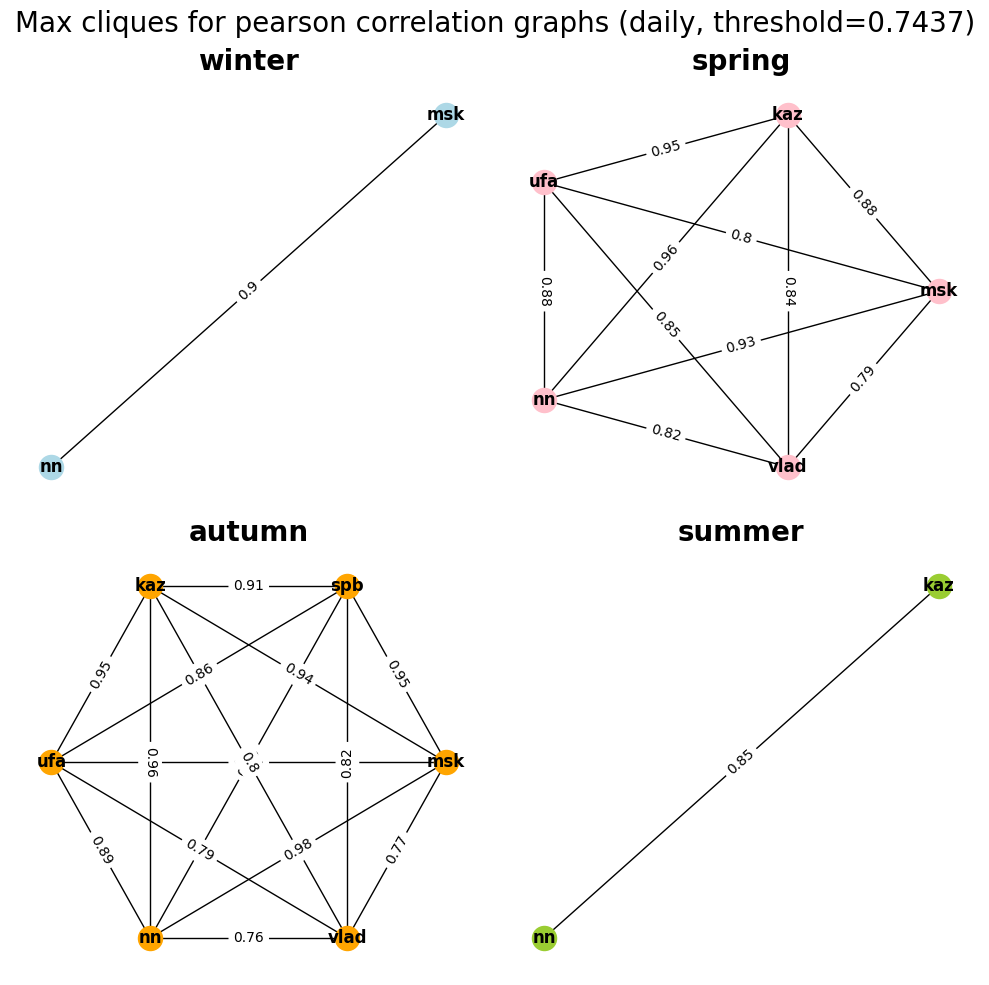

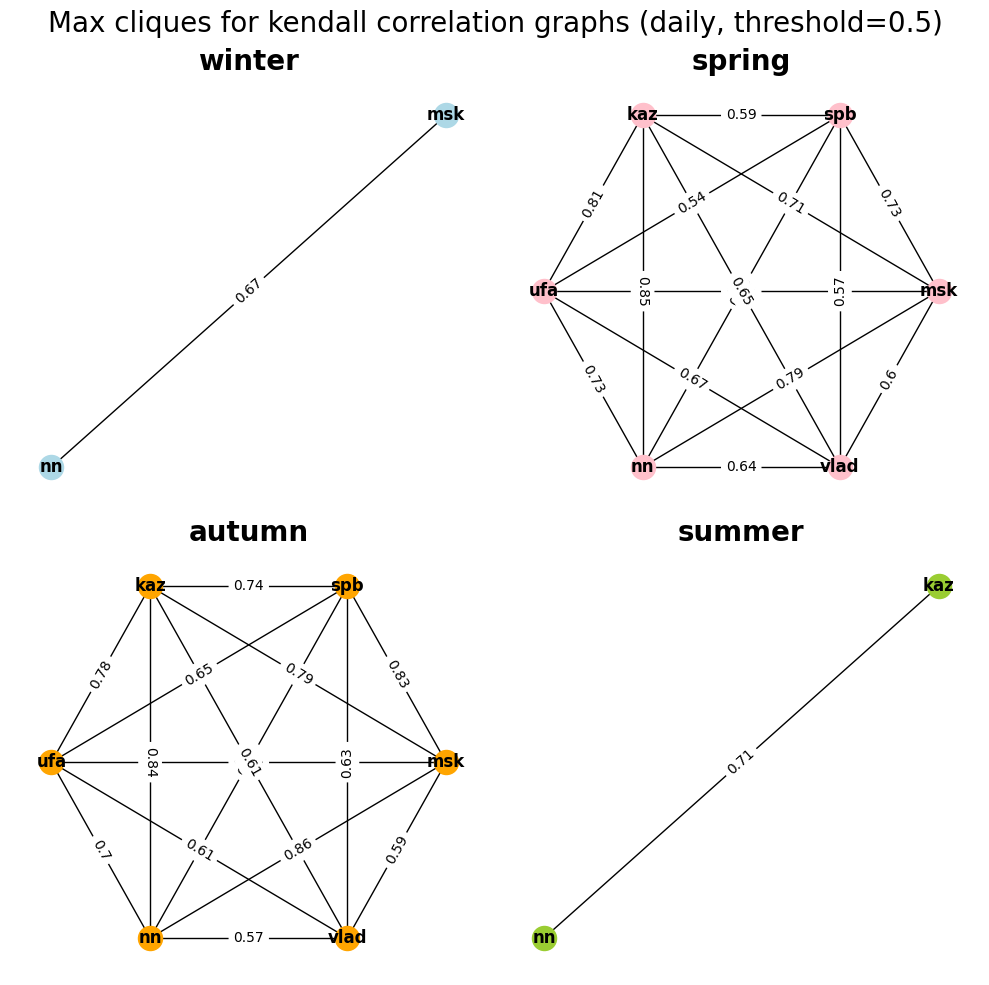

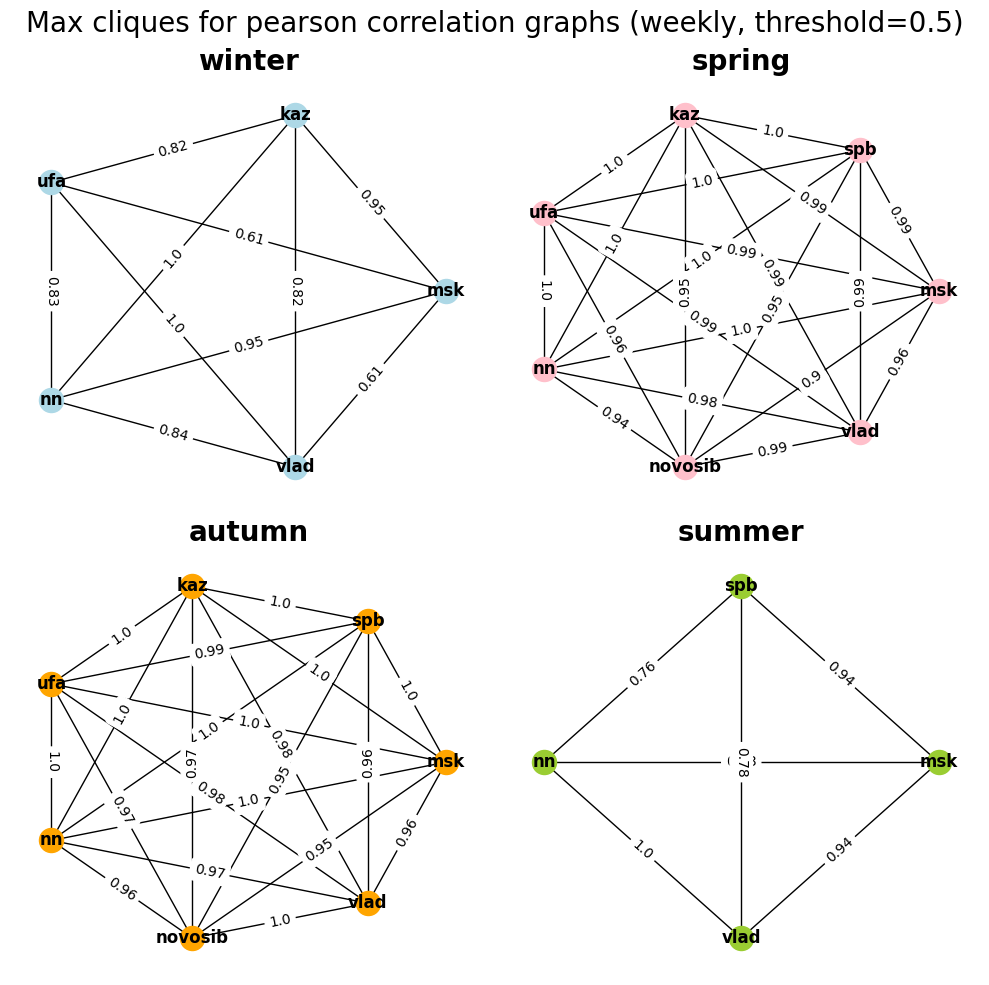

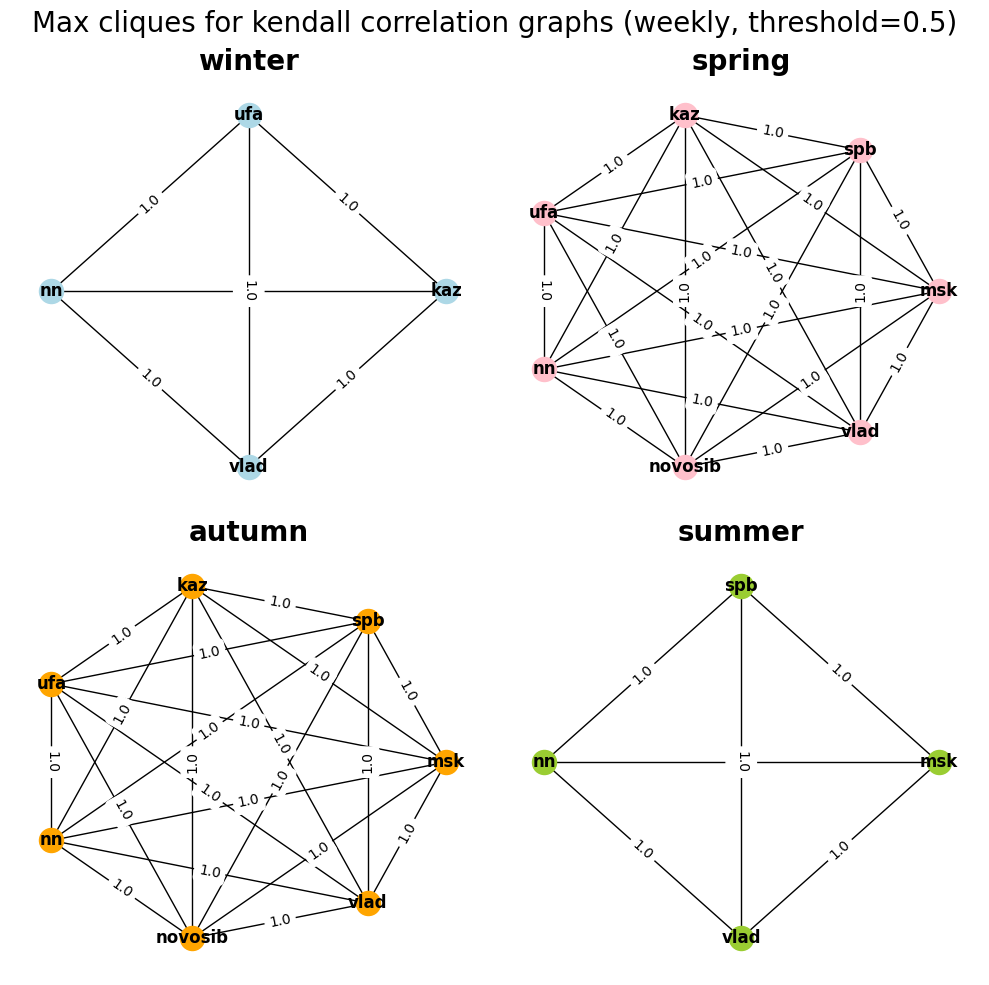

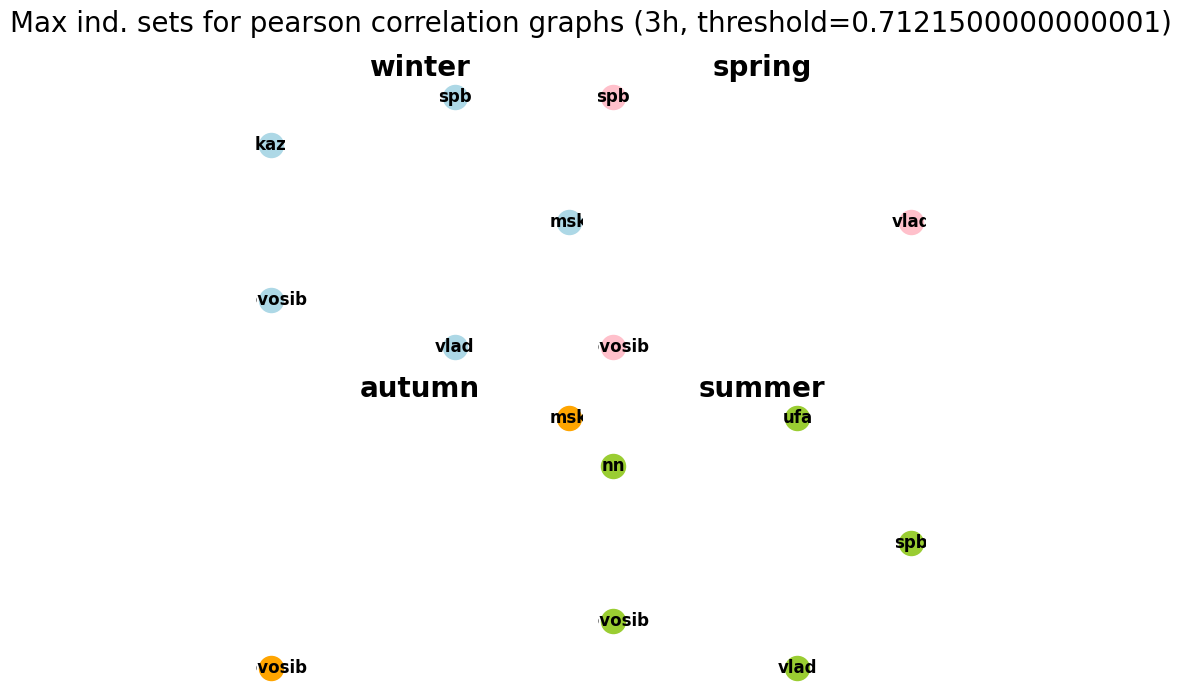

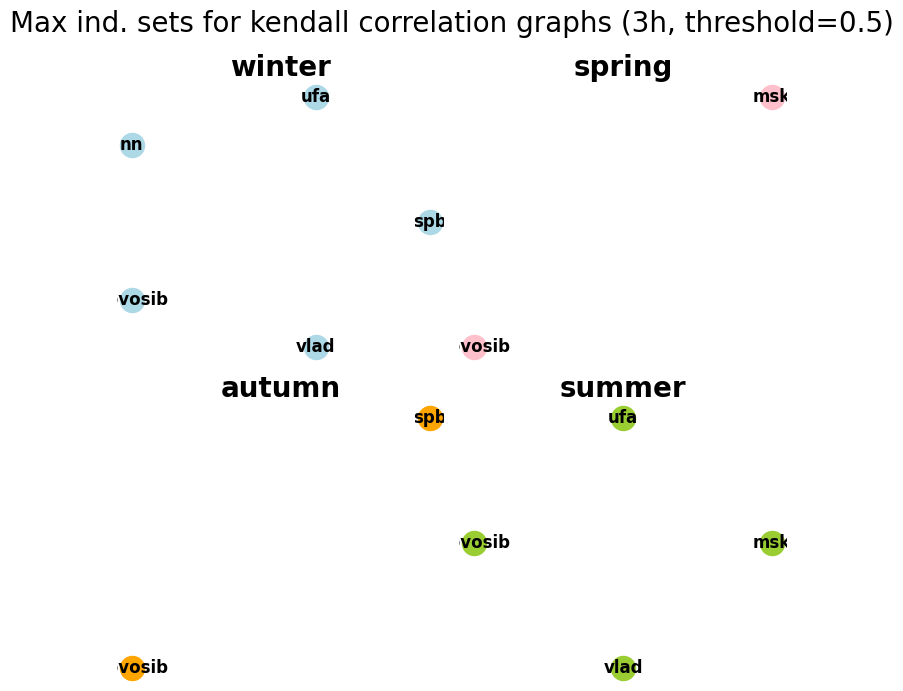

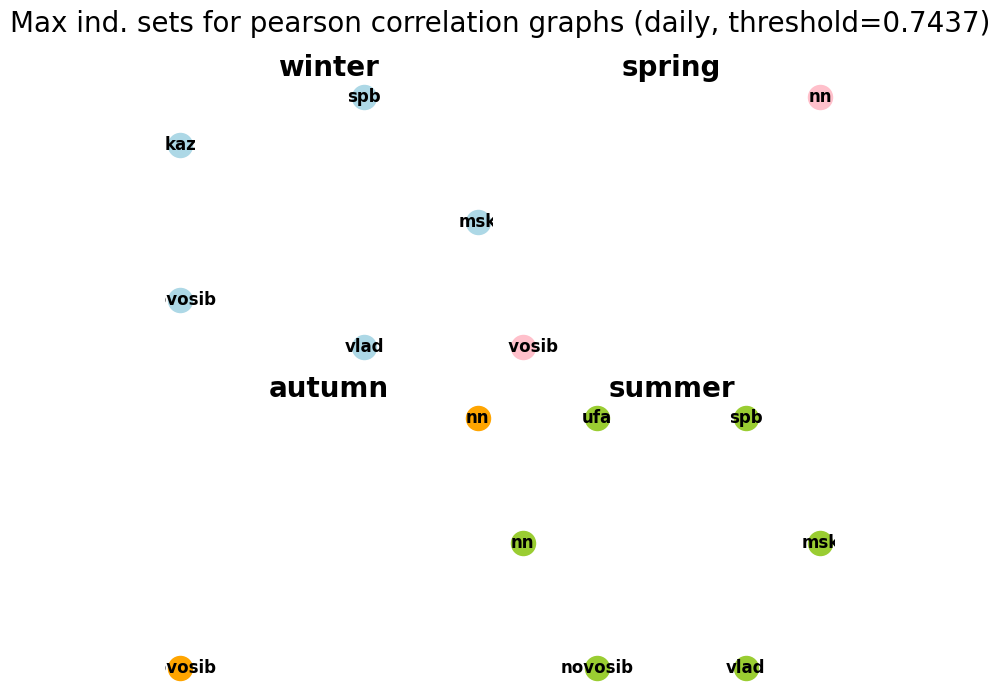

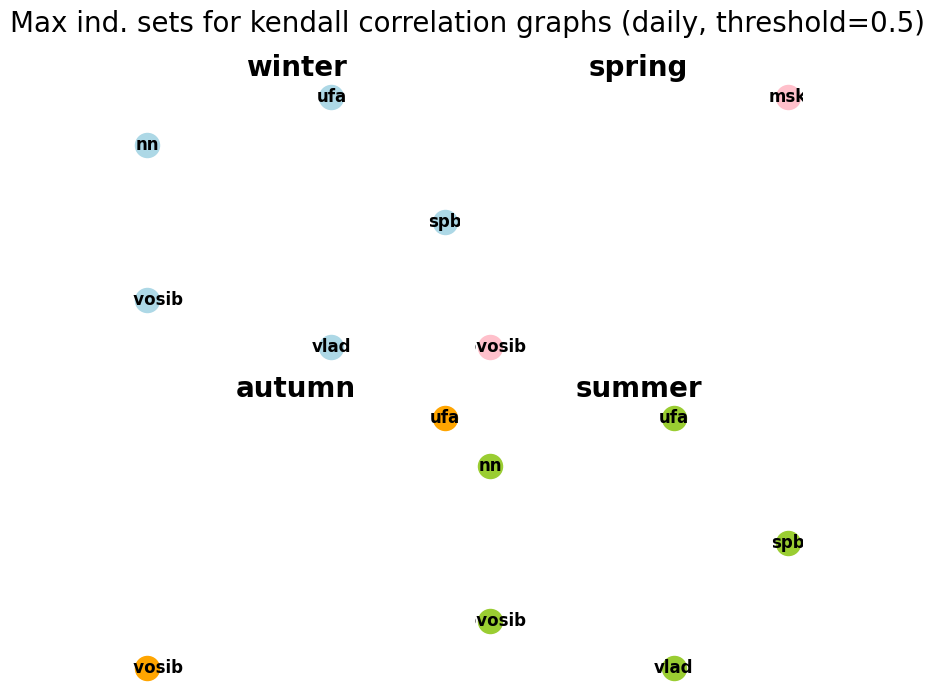

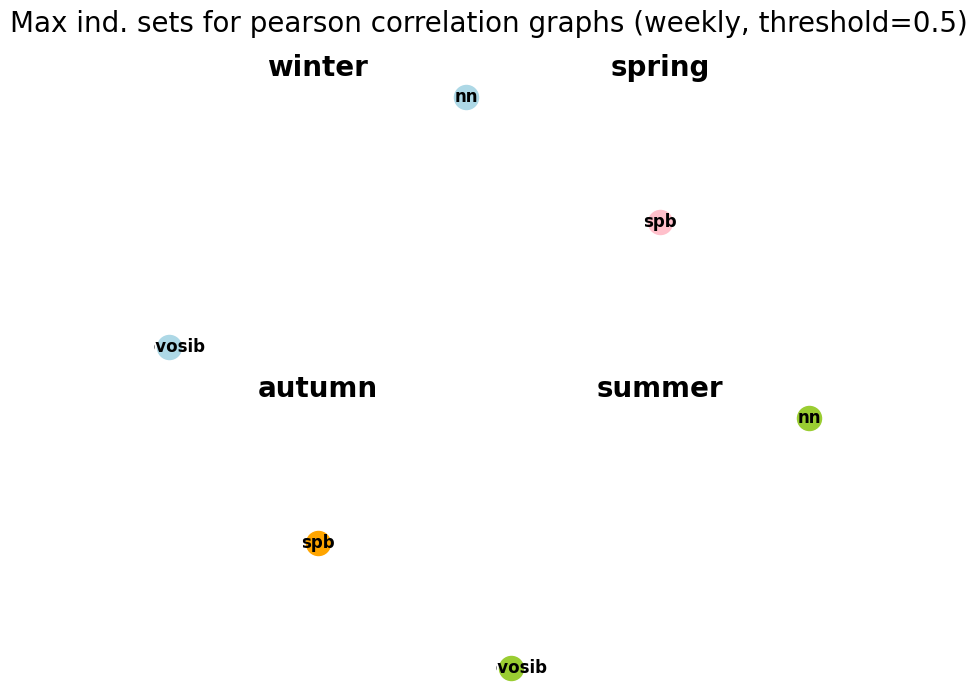

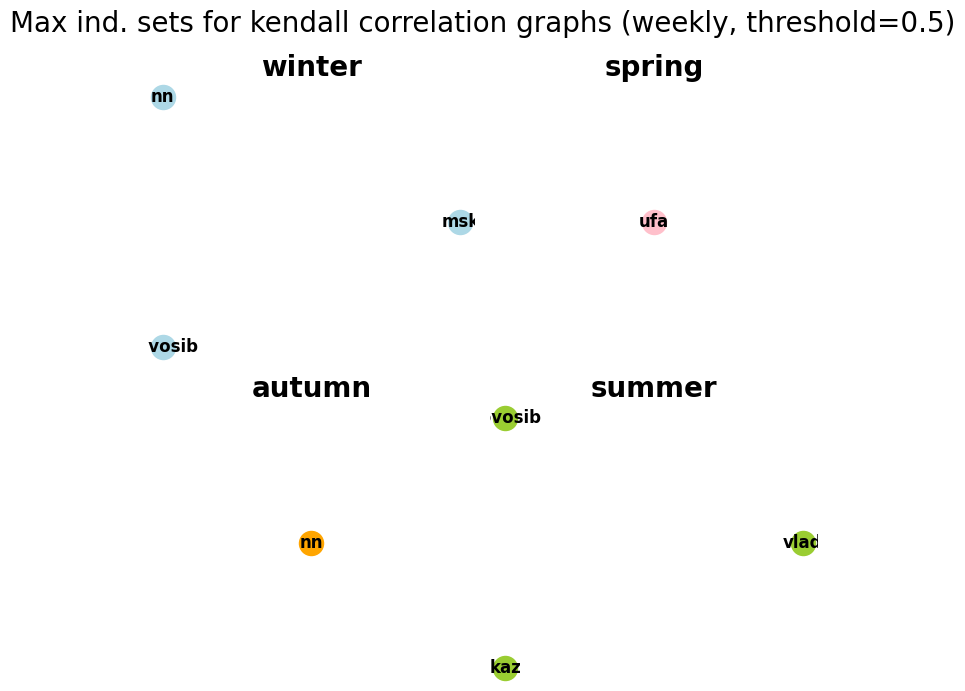

In [27]:
intervals = ["3h", "daily", "weekly"]
methods = ["pearson", "kendall"]

for interval in intervals:
    for corr_method in methods:
        draw_graph_forall_seasons_by_interval(interval, corr_method)

for interval in intervals:
    for corr_method in methods:
        draw_cliques_forall_seasons_by_interval(interval, corr_method)


for interval in intervals:
    for corr_method in methods:
        draw_sets_forall_seasons_by_interval(interval, corr_method)

In [28]:

df = pd.DataFrame({
    'moscow': [28.0, 23.0, 28.0, 22.0, 22.0, 16.0, 25.0, 24.0, 20.0, 18.0],
    'spb': [10.0, 21.0, 21.0, 17.0, 21.0, 11.0, 22.0, 10.0, 13.0, 21.0],
    'kazan': [21.0, 23.0, 23.0, 20.0, 23.0, 26.0, 32.0, 22.0, 22.0, 24.0],
    'ufa': [16.0, 11.0, 19.0, 14.0, 18.0, 19.0, 17.0, 11.0, 17.0, 11.0],
    'nizhny': [20.0, 20.0, 15.0, 19.0, 16.0, 22.0, 15.0, 17.0, 18.0, 18.0],
})


df.corr(method='pearson')
vertices = ['moscow', 'spb', 'kazan', 'ufa', 'nizhny']
edge_weights = compute_pearson_correlation(df)

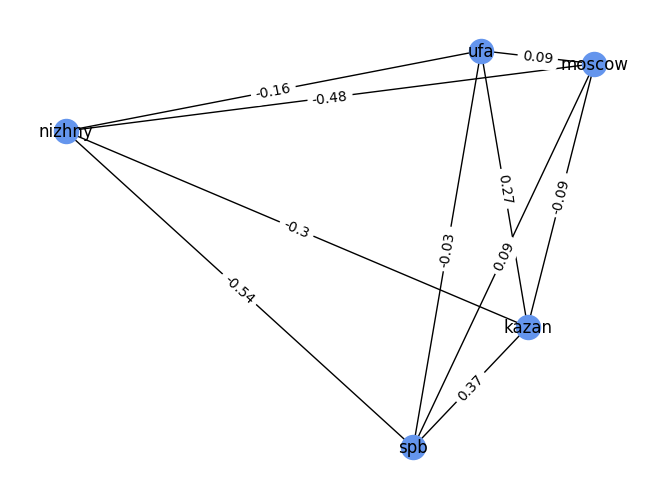

In [29]:
g_full = build_full_graph(vertices, edge_weights)
pos = nx.spring_layout(g_full)
nx.draw(g_full, pos, with_labels=True, node_color='cornflowerblue')
edge_labels = {k: round(v, 2) for (k, v) in nx.get_edge_attributes(g_full, 'weight').items()}
nx.draw_networkx_edge_labels(g_full, pos, edge_labels);

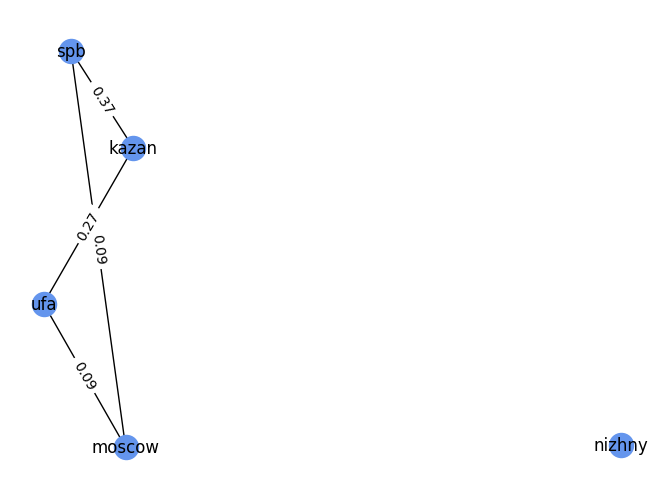

In [30]:
g = build_threshold_graph(vertices, edge_weights, threshold=0.0)
pos = nx.spring_layout(g)
nx.draw(g, pos, with_labels=True, node_color='cornflowerblue')
edge_labels = {k: round(v, 2) for (k, v) in nx.get_edge_attributes(g, 'weight').items()}
nx.draw_networkx_edge_labels(g, pos, edge_labels);

In [31]:
find_max_clique(g)

In [32]:
find_max_independent_set(g)